In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Data exploration

In [3]:
data = pd.read_csv("../datasets/EGFR/raw/EGFR_compounds_lipinsky.csv", index_col=0)
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


First I want to know which columns contain relevant information and what they represent. On first glance it seems like the `units` and `ro5_fulfulled` columns contain the same values for all rows. If this is true, we can ignore these columns. 

In [4]:
print(data["units"].unique())
print(data["ro5_fulfilled"].unique())

['nM']
[ True]


`molecule_chembl_id`: the identifier of the molecule in the ChEMBL dataset (bioactive molecules with drug-like properties). 

`IC50`: the amount of substance needed to inhibit a process (*in vitro*) by 50%  
`pIC50`: -log10(IC50)

`smiles`: [SMILES strings](https://docs.eyesopen.com/toolkits/python/glossary.html#term-SMARTS) represent a molecule by describing its molecular graph. This can be used to build a molecule graph (e.g. for PyTorch Geometric). Alternatively, 2D molecular descriptors (e.g. structural keys) can be used. Strutural keys such as MACCS keys are binary bit strings where each bit represents a pre-defined feature (e.g. substructure/fragment). These keys can compared in a similar manner as embeddings, and similarity between two molecules can be computed using the Hamming distance. 

The following features affect the absorption and permeation properties of the molecule, which are important for evaluating the molecule as a drug candidate, but are unlikely to affect the potency value. I would include them in a more general model where the aim is to predict the general potential of the molecule as a drug, but not in the current task, where I am only interested in predicting pIC50. 

`molecular weight`: The [Lipinsky rule of 5](https://www.sciencedirect.com/science/article/pii/S0169409X96004231) states that poor absorption or permeation is more likely when the molecular weight is over 500

`n_hba`: number of H-bond acceptors. The Rule of 5 applies when there are more than 10 H-bond acceptors

`n_hbd`: number of H-bond donors. The Rule of 5 applies when there are more than 5 H-bond donors. 

`logp`: The Rule of 5 applies when LogP is over 5. 

## Data distribution

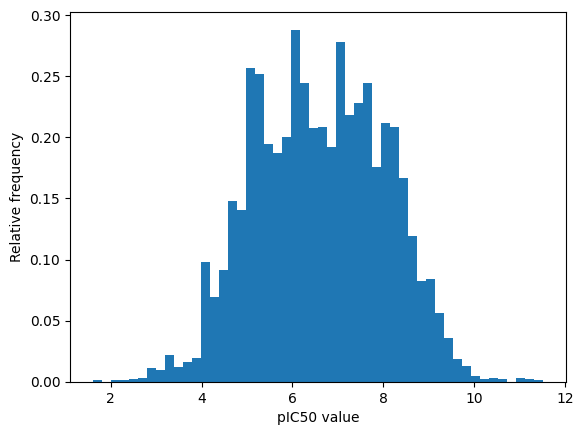

In [6]:
pIC50 = data["pIC50"].to_numpy()
plt.hist(pIC50, bins=50, density=True)
plt.xlabel("pIC50 value")
plt.ylabel("Relative frequency")
plt.show()

The dataset is relatively evenly distributed, the values we are interested in, pIC50 > 8 are not in the extreme tail end of the distribution, and there are no gaps in the data. 

# A baseline for the regression task

Even though we are asked to predict whether compounds have a pIC50 > 8, I believe framing this as a regression task which outputs the pIC50 value is more appropriate beceause:

1. pIC50 is a continous variable
2. I cannot think of a reason which would make compounds with pIC50 slighly higher than 8 *categorically different* from compounds with pIC50 slightly lower than 8. Therefore I don't think it makes sense to build a classification model which would spend more resources on learning the slight differences between molecules with pIC50 $\approx 8$. However, if this assumption is wrong, and there is a reason for an absolute cut-off at pIC50 = 8, a classifcation model would be more appropriate.  

I first use a random forest regressor to establish a baseline for the problem, with which I will compare the results of my main approach (finetuning using a pre-trained [GraphGPS](https://arxiv.org/abs/2205.12454) model). 

For this baseline model, I will encode the SMILES strings as MACCS structural keys, as in the [cheminfomatics tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T007_compound_activity_machine_learning.html). In this section, the SMILES strings are converted, each bit of the MACCS key is treated as an independent variable, and the test-train split is done. 

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [16]:
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return list(MACCSkeys.GenMACCSKeys(mol))

In [18]:
data["maccs"] = data["smiles"].apply(smiles_to_maccs)

In [22]:
X = pd.DataFrame(data["maccs"].to_list(), columns=["maccs_{0}".format(i) for i in range(167)])
X.head()

,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


In [26]:
y = data["pIC50"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next I set up the model and performed a randomized hyperparameter search using cross validation

In [29]:
model = RandomForestRegressor(n_estimators=100)
params = {
    "max_depth": [2, 3, None], # default None
    "max_leaf_nodes": [10, 20, None], # default None
    "min_samples_split": [2, 10], # default 2
    "max_features": ["sqrt", None], # default None=n_features
    "min_samples_leaf":[1, 2, 5], # default is 1
    "n_estimators": [100, 200], # default 100
}

clf = RandomizedSearchCV(model, params, n_iter=20)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [2, 3, None],
                                        'max_features': ['sqrt', None],
                                        'max_leaf_nodes': [10, 20, None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [100, 200]})

In [30]:
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,1.381701,0.008388,0.010020,0.000104,100,10,1,None,None,None,"{'n_estimators': 100, 'min_samples_split': 10,...",0.581636,0.623563,0.587659,0.605771,0.592439,0.598214,0.014962,1
4,1.507782,0.015440,0.009581,0.000140,200,10,2,20,None,None,"{'n_estimators': 200, 'min_samples_split': 10,...",0.425751,0.457969,0.448446,0.461214,0.452223,0.449120,0.012496,2
11,0.769769,0.010891,0.005546,0.000093,100,2,1,20,None,None,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.423505,0.454352,0.453113,0.458713,0.453891,0.448715,0.012755,3
18,0.201496,0.001187,0.009995,0.000049,200,10,5,20,sqrt,None,"{'n_estimators': 200, 'min_samples_split': 10,...",0.385465,0.406043,0.383635,0.386762,0.378449,0.388071,0.009421,4
5,0.101009,0.000373,0.005517,0.000030,100,10,2,20,sqrt,None,"{'n_estimators': 100, 'min_samples_split': 10,...",0.382078,0.410589,0.377863,0.381554,0.376241,0.385665,0.012655,5


I build a model using the best hyperparameters found, and apply it to the test set

In [31]:
results["params"][9]

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': None,
 'max_features': None,
 'max_depth': None}

In [35]:
model_best = RandomForestRegressor(n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_leaf_nodes=None, max_features=None, max_depth=None)
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)
mae = np.mean(np.abs(y_pred-y_test))
print("Mean absolute error: {0}".format(mae))

Mean absolute error: 0.6617428062542967
